In [6]:
!pip3 install pytorch-transformers==1.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 18.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [7]:
# NOTE: This is specific to Google Colab to change the working directory. Use this to point to the path that contains Sarcasm_Headlines_Dataset.json file.
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [8]:
!pwd

/content/drive/MyDrive/Colab Notebooks


In [9]:
ls

 COGS185_SP24_HW3/                         '““HW3_DNNs_&_CNNs_ipynb”的副本 (1)”的副本'
 “CSE151A_HW1.ipynb”的副本                 '“HW4_NB_&_SVMs.ipynb”的副本'
 “CSE_151A_HW2.ipynb”的副本                 “HW5_Clustering_and_PCA.ipynb”的副本
'“CSE_151A_HW2.ipynb”的副本 (1)'            Sarcasm_Headlines_Dataset.json
'data hw4.csv'                              Untitled
'“HW3_DNNs_&_CNNs.ipynb”的副本'             Untitled0.ipynb
'“HW3_DNNs_&_CNNs_ipynb”的副本 (1).ipynb'   Untitled16.ipynb


In [10]:
import random
import numpy as np
import os
import torch
import torch.nn as nn
from pytorch_transformers import BertModel, BertTokenizer, BertConfig, WarmupLinearSchedule
import re
import pandas as pd
import json
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm import tqdm, trange

def seed_everything(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# For reproducible results
seed_everything()

In [11]:
# Constants

SEP_TOKEN = '[SEP]'
CLS_TOKEN = '[CLS]'
TRAIN_FILE_PATH = 'Sarcasm_Headlines_Dataset.json'
MAX_SEQ_LENGTH = 512
BATCH_SIZE = 4
NUM_EPOCHS = 6
GRADIENT_ACCUMULATION_STEPS = 8
WARMUP_STEPS = 3
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [12]:
class BertClassifier(nn.Module):

    def __init__(self, config):
        super(BertClassifier, self).__init__()
        # Binary classification problem (num_labels = 2)
        self.num_labels = config.num_labels
        # Pre-trained BERT model
        self.bert = BertModel(config)
        # Dropout to avoid overfitting
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # A single layer classifier added on top of BERT to fine tune for binary classification
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Weight initialization
        torch.nn.init.xavier_normal_(self.classifier.weight)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None,
                position_ids=None, head_mask=None):
        # Forward pass through pre-trained BERT
        outputs = self.bert(input_ids, position_ids=position_ids, token_type_ids=token_type_ids,
                            attention_mask=attention_mask, head_mask=head_mask)

        # Last layer output (Total 12 layers)
        pooled_output = outputs[-1]
        pooled_output = pooled_output.detach()   # Stop gradient to prevent bert encoder from being fine-tuned

        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

In [13]:
class SequenceDataset(Dataset):
    def __init__(self, dataset_file_path, tokenizer, regex_transformations={}):
        # Read JSON file and assign to headlines variable (list of strings)
        df = pd.read_json(dataset_file_path, lines=True)
        print (df)
        df = df.drop(['article_link'], axis=1)
        self.headlines = df.values
        # Regex Transformations can be used for data cleansing.
        # e.g. replace
        #   '\n' -> ' ',
        #   'wasn't -> was not
        self.regex_transformations = regex_transformations
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, index):
        headline, is_sarcastic = self.headlines[index]
        for regex, value_to_replace_with in self.regex_transformations.items():
            headline = re.sub(regex, value_to_replace_with, headline)

        # Convert input string into tokens with the special BERT Tokenizer which can handle out-of-vocabulary words using subgrams
        # e.g. headline = Here is the sentence I want embeddings for.
        #      tokens = [here, is, the, sentence, i, want, em, ##bed, ##ding, ##s, for, .]
        tokens = self.tokenizer.tokenize(headline)

        # Add [CLS] at the beginning and [SEP] at the end of the tokens list for classification problems
        tokens = [CLS_TOKEN] + tokens + [SEP_TOKEN]
        # Convert tokens to respective IDs from the vocabulary
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)

        # Segment ID for a single sequence in case of classification is 0.
        segment_ids = [0] * len(input_ids)

        # Input mask where each valid token has mask = 1 and padding has mask = 0
        input_mask = [1] * len(input_ids)

        # padding_length is calculated to reach max_seq_length
        padding_length = MAX_SEQ_LENGTH - len(input_ids)
        input_ids = input_ids + [0] * padding_length
        input_mask = input_mask + [0] * padding_length
        segment_ids = segment_ids + [0] * padding_length

        assert len(input_ids) == MAX_SEQ_LENGTH
        assert len(input_mask) == MAX_SEQ_LENGTH
        assert len(segment_ids) == MAX_SEQ_LENGTH

        return torch.tensor(input_ids, dtype=torch.long, device=DEVICE), \
               torch.tensor(segment_ids, dtype=torch.long, device=DEVICE), \
               torch.tensor(input_mask, device=DEVICE), \
               torch.tensor(is_sarcastic, dtype=torch.long, device=DEVICE)

In [14]:
# Load BERT default config object and make necessary changes as per requirement
config = BertConfig(hidden_size=768,
                    num_hidden_layers=12,
                    num_attention_heads=12,
                    intermediate_size=3072,
                    num_labels=2)

# Create our custom BERTClassifier model object
model = BertClassifier(config)
model.to(DEVICE)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 358332.55B/s]


In [ ]:
#train_dataset

In [15]:
# Load Train dataset and split it into Train and Validation dataset
train_dataset = SequenceDataset(TRAIN_FILE_PATH, tokenizer)

validation_split = 0.4

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
shuffle_dataset = True

if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=validation_sampler)

print ('Training Set Size {}, Validation Set Size {}'.format(len(train_indices), len(val_indices)))

                                           article_link  \
0     https://www.huffingtonpost.com/entry/versace-b...   
1     https://www.huffingtonpost.com/entry/roseanne-...   
2     https://local.theonion.com/mom-starting-to-fea...   
3     https://politics.theonion.com/boehner-just-wan...   
4     https://www.huffingtonpost.com/entry/jk-rowlin...   
...                                                 ...   
2994  https://www.huffingtonpost.com/entry/military-...   
2995  https://www.huffingtonpost.com/entry/trump-adm...   
2996  https://www.huffingtonpost.com/entry/we-found-...   
2997  https://www.huffingtonpost.com/entry/what-if-e...   
2998  https://www.theonion.com/bird-has-big-plans-fo...   

                                               headline  is_sarcastic  
0     former versace store clerk sues over secret 'b...             0  
1     the 'roseanne' revival catches up to our thorn...             0  
2     mom starting to fear son's web series closest ...             1  
3  

In [16]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Adam Optimizer with very small learning rate given to BERT
learning_rates = [1e-5, 2e-5, 3e-5]
best_train_acc, best_val_acc = 0, 0
for lr in learning_rates:
    optimizer = torch.optim.Adam([
        {'params': model.classifier.parameters(), 'lr': lr}
    ])
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=WARMUP_STEPS, t_total=len(train_loader) // GRADIENT_ACCUMULATION_STEPS * NUM_EPOCHS)

    model.zero_grad()
    epoch_iterator = trange(int(NUM_EPOCHS), desc="Epoch")
    training_acc_list, validation_acc_list = [], []

for epoch in epoch_iterator:
    epoch_loss = 0.0
    train_correct_total = 0

    # Training Loop
    train_iterator = tqdm(train_loader, desc="Train Iteration")
    for step, batch in enumerate(train_iterator):
        model.train(True)
        # Here each element of batch list refers to one of [input_ids, segment_ids, attention_mask, labels]
        inputs = {
            'input_ids': batch[0].to(DEVICE),
            'token_type_ids': batch[1].to(DEVICE),
            'attention_mask': batch[2].to(DEVICE)
        }

        labels = batch[3].to(DEVICE)
        logits = model(**inputs)

        loss = criterion(logits, labels) / GRADIENT_ACCUMULATION_STEPS
        loss.backward()
        epoch_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            scheduler.step()
            optimizer.step()
            model.zero_grad()

        _, predicted = torch.max(logits.data, 1)
        correct_reviews_in_batch = (predicted == labels).sum().item()
        train_correct_total += correct_reviews_in_batch

    print('Epoch {} - Loss {:.2f}'.format(epoch + 1, epoch_loss / len(train_indices)))

    # Validation Loop
    with torch.no_grad():
        val_correct_total = 0
        model.train(False)
        val_iterator = tqdm(val_loader, desc="Validation Iteration")
        for step, batch in enumerate(val_iterator):
            inputs = {
                'input_ids': batch[0].to(DEVICE),
                'token_type_ids': batch[1].to(DEVICE),
                'attention_mask': batch[2].to(DEVICE)
            }

            labels = batch[3].to(DEVICE)
            logits = model(**inputs)

            _, predicted = torch.max(logits.data, 1)
            correct_reviews_in_batch = (predicted == labels).sum().item()
            val_correct_total += correct_reviews_in_batch

        training_acc_list.append(train_correct_total * 100 / len(train_indices))
        validation_acc_list.append(val_correct_total * 100 / len(val_indices))
        print('Training Accuracy {:.4f} - Validation Accurracy {:.4f}'.format(train_correct_total * 100 / len(train_indices), val_correct_total * 100 / len(val_indices)))

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]


Train Iteration:   0%|          | 1/450 [00:02<15:44,  2.10s/it]

Train Iteration:   0%|          | 2/450 [00:02<07:17,  1.02it/s]

Train Iteration:   1%|          | 3/450 [00:02<04:34,  1.63it/s]

Train Iteration:   1%|          | 4/450 [00:02<03:11,  2.32it/s]

Train Iteration:   1%|          | 5/450 [00:02<02:26,  3.04it/s]

Train Iteration:   1%|▏         | 6/450 [00:02<01:59,  3.71it/s]

Train Iteration:   2%|▏         | 7/450 [00:03<01:42,  4.34it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjus

Epoch 1 - Loss 0.02



Epoch:  17%|█▋        | 1/6 [02:03<10:19, 123.80s/it]

Training Accuracy 55.0000 - Validation Accurracy 56.5471



Train Iteration: 100%|██████████| 450/450 [01:16<00:00,  5.88it/s]


Epoch 2 - Loss 0.02



Epoch:  33%|███▎      | 2/6 [04:09<08:19, 124.76s/it]

Training Accuracy 52.9444 - Validation Accurracy 56.3803



Train Iteration: 100%|██████████| 450/450 [01:16<00:00,  5.85it/s]


Epoch 3 - Loss 0.02



Epoch:  50%|█████     | 3/6 [06:15<06:16, 125.49s/it]

Training Accuracy 51.1667 - Validation Accurracy 56.1301



Train Iteration: 100%|██████████| 450/450 [01:16<00:00,  5.87it/s]


Epoch 4 - Loss 0.02



Epoch:  67%|██████▋   | 4/6 [08:21<04:11, 125.54s/it]

Training Accuracy 50.2778 - Validation Accurracy 55.9633



Train Iteration: 100%|██████████| 450/450 [01:16<00:00,  5.88it/s]


Epoch 5 - Loss 0.02



Epoch:  83%|████████▎ | 5/6 [10:26<02:05, 125.51s/it]

Training Accuracy 51.8889 - Validation Accurracy 56.0467



Train Iteration: 100%|██████████| 450/450 [01:16<00:00,  5.87it/s]


Epoch 6 - Loss 0.02



Epoch: 100%|██████████| 6/6 [12:32<00:00, 125.38s/it]

Training Accuracy 54.0000 - Validation Accurracy 56.1301


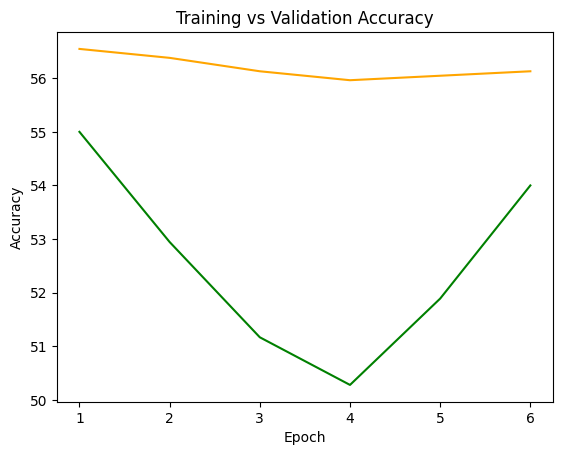

In [17]:
import matplotlib.pyplot as plt

epochs_list = list(range(1, NUM_EPOCHS + 1))
plt.plot(epochs_list, training_acc_list, color='g')
plt.plot(epochs_list, validation_acc_list, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

In [18]:
train_correct_total * 100 / len(train_indices)

54.0